<a href="https://colab.research.google.com/github/Hyun-ho-Lee/Python-Practice/blob/main/inflearn_MLP_(12_08)ipynb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from sklearn.datasets import load_boston
import pandas as pd 
import numpy as np
from sklearn.model_selection import train_test_split 
from sklearn.preprocessing import MinMaxScaler 

import torch 
from torch import nn , optim
from torch.utils.data import DataLoader,Dataset 
import torch.nn.functional as F

from sklearn.metrics import mean_squared_error

import matplotlib.pyplot as plt 

In [ ]:
bos = load_boston()

In [4]:
df = pd.DataFrame(bos.data)
df.columns = bos.feature_names
df['Price'] = bos .target 
df.head(10)

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,Price
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2
5,0.02985,0.0,2.18,0.0,0.458,6.430,58.7,6.0622,3.0,222.0,18.7,394.12,5.21,28.7
6,0.08829,12.5,7.87,0.0,0.524,6.012,66.6,5.5605,5.0,311.0,15.2,395.60,12.43,22.9
7,0.14455,12.5,7.87,0.0,0.524,6.172,96.1,5.9505,5.0,311.0,15.2,396.90,19.15,27.1
8,0.21124,12.5,7.87,0.0,0.524,5.631,100.0,6.0821,5.0,311.0,15.2,386.63,29.93,16.5
9,0.17004,12.5,7.87,0.0,0.524,6.004,85.9,6.5921,5.0,311.0,15.2,386.71,17.10,18.9


In [5]:
X = df.drop('Price',axis=1).to_numpy()
Y = df['Price'].to_numpy().reshape((-1,1))

In [7]:
scaler = MinMaxScaler()
scaler.fit(X)
X = scaler.transform(X)
scaler.fit(Y)
Y = scaler.transform(Y)

In [8]:
class TensorData(Dataset):

    def __init__(self,x_data,y_data):
        self.x_data = torch.FloatTensor(x_data)
        self.y_data = torch.FloatTensor(y_data)
        self.len = self.y_data.shape[0]

    
    def __getitem__(self,index):
      
        return self.x_data[index],self.y_data[index]
    
    def __len__(self):
        
        return self.len

In [11]:
X_train,X_test,Y_train,Y_test = train_test_split(X,Y,test_size = 0.5)

trainsets = TensorData(X_train,Y_train)
trainloader = torch.utils.data.DataLoader(trainsets,batch_size=32,shuffle=32)

testsets = TensorData(X_test,Y_test)
testloader = torch.utils.data.DataLoader(testsets,batch_size=32,shuffle=32)

In [12]:
class Regressor(nn.Module): 
    
    def __init__(self): 
        super().__init__()
        self.fc1 = nn.Linear(13,50,bias=True) #layer 1 에서 feature 갯수인 13 받아서 hidden 50 으로 감 
        self.fc2 = nn.Linear(50,30,bias=True) # hidden 1 에서 받은 50 을 hidden2 30으로 넘김
        self.fc3 = nn.Linear(30,1,bias=True)  # hidden2에서 받은 30을 1로 넘김
        self.dropout = nn.Dropout(0.2)  #연산이 될 때마다 20% 비율로 랜덤하게 노드를 없앰 

    def forward(self,x):
        x = F.relu(self.fc1(x)) 
        x = self.dropout(F.relu(self.fc2(x)))
        x = F.relu(self.fc3(x))

        return x 

In [14]:
model = Regressor()
criterion = nn.MSELoss()

optimizer = optim.Adam(model.parameters(),lr = 0.001 , weight_decay=1e-7)

In [16]:
loss_ = []

n = len(trainloader)

for epoch in range(400):
    
    running_loss = 0.0

    for i , data in enumerate(trainloader,0) :
        
        inputs, values = data 

        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs,values)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    loss_.append(np.sqrt(running_loss)/n)

print('Finish')

Finish


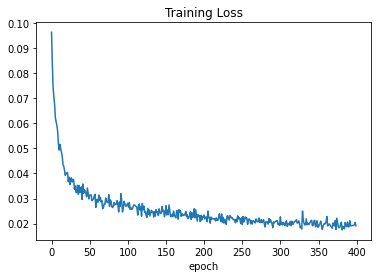

In [18]:
plt.plot(loss_)
plt.title("Training Loss")
plt.xlabel("epoch")
plt.show()

In [21]:
def evaluation(dataloader):

    predictions = torch.tensor([],dtype = torch.float)
    actual = torch.tensor([],dtype = torch.float)

    with torch.no_grad(): # torch.no_gard() 최적화를 하는게 아님  #eval 사용시 평가할때 dropout 사용 안함 
        model.eval()
        for data in dataloader: 
            inputs, values = data 
            outputs = model(inputs)

            predictions = torch.cat((predictions,outputs),0)
            actual = torch.cat((actual,values),0)
        
    prediction = predictions.numpy()
    actual = actual.numpy()
    rmse = np.sqrt(mean_squared_error(predictions,actual))

    return rmse

In [23]:
train_rmse = evaluation(trainloader)
test_rmse = evaluation(testloader)

print("Train RMSE",train_rmse)
print("Test RMSE",test_rmse)

Train RMSE 0.040948115
Test RMSE 0.10111744
